# Open AI Gym

In [1]:
import gym

from gym import wrappers
import io
import base64
from IPython.display import HTML

env = gym.make('BreakoutDeterministic-v4') # frame skipping 
env = wrappers.Monitor(env, "./gym-results", force=True) # Cache game

frame = env.reset() 
# env.render()

is_done = False
while not is_done: 
    frame, reward, is_done, _ = env.step(env.action_space.sample())
#     env.render()
env.close()
    
video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

# Preprocessing

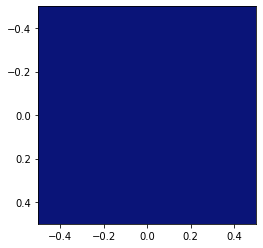

[[50]]


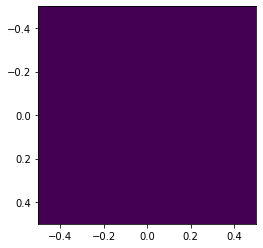

array([[50]], dtype=uint8)

In [10]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

pixel_example = np.array([ [ [10, 20, 120] ] ]) #, [20, 40, 30] ] ])
plt.imshow(pixel_example)
plt.show()

def convert_rgb_to_grayscale(image): 
    grayscale = np.mean(image, axis=2).astype(np.uint8)
    print(grayscale)
    plt.imshow(grayscale)
    plt.show()
    return np.mean(image, axis=2).astype(np.uint8)

# assert True == False

convert_rgb_to_grayscale(pixel_example)

# def downsample(img): 

In [5]:
# Preprocess 
def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

def downsample(img):
    return img[::2, ::2]

def preprocess(img):
    return to_grayscale(downsample(img))

# Normalize rewards 
def transform_reward(reward):
        return np.sign(reward)

In [6]:
# Ring Buffer 
class RingBuf:
    def __init__(self, size):
        # Pro-tip: when implementing a ring buffer, always allocate one extra element,
        # this way, self.start == self.end always means the buffer is EMPTY, whereas
        # if you allocate exactly the right number of elements, it could also mean
        # the buffer is full. This greatly simplifies the rest of the code.
        self.data = [None] * (size + 1)
        self.start = 0
        self.end = 0
        
    def append(self, element):
        self.data[self.end] = element
        self.end = (self.end + 1) % len(self.data)
        # end == start and yet we just added one element. This means the buffer has one
        # too many element. Remove the first element by incrementing start.
        if self.end == self.start:
            self.start = (self.start + 1) % len(self.data)
        
    def __getitem__(self, idx):
        return self.data[(self.start + idx) % len(self.data)]
    
    def __len__(self):
        if self.end < self.start:
            return self.end + len(self.data) - self.start
        else:
            return self.end - self.start
        
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

In [2]:
# Fit 
def fit_batch(model, gamma, start_states, actions, rewards, next_states, is_terminal):
    """Do one deep Q learning iteration.
    
    Params:
    - model: The DQN
    - gamma: Discount factor (should be 0.99)
    - start_states: numpy array of starting states
    - actions: numpy array of one-hot encoded actions corresponding to the start states
    - rewards: numpy array of rewards corresponding to the start states and actions
    - next_states: numpy array of the resulting states corresponding to the start states and actions
    - is_terminal: numpy boolean array of whether the resulting state is terminal
    
    """
    # First, predict the Q values of the next states. Note how we are passing ones as the mask.
    next_Q_values = model.predict([next_states, np.ones(actions.shape)])
    # The Q values of the terminal states is 0 by definition, so override them
    next_Q_values[is_terminal] = 0
    # The Q values of each start state is the reward + gamma * the max next state Q value
    Q_values = rewards + gamma * np.max(next_Q_values, axis=1)
    # Fit the keras model. Note how we are passing the actions as the mask and multiplying
    # the targets by the actions.
    model.fit(
        [start_states, actions], actions * Q_values[:, None],
        nb_epoch=1, batch_size=len(start_states), verbose=0
    )

# Model 
def atari_model(n_actions):
    # We assume a theano backend here, so the "channels" are first.
    ATARI_SHAPE = (4, 105, 80)

    # With the functional API we need to define the inputs.
    frames_input = keras.layers.Input(ATARI_SHAPE, name='frames')
    actions_input = keras.layers.Input((n_actions,), name='mask')

    # Assuming that the input frames are still encoded from 0 to 255. Transforming to [0, 1].
    normalized = keras.layers.Lambda(lambda x: x / 255.0)(frames_input)
    
    # "The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity."
    conv_1 = keras.layers.convolutional.Convolution2D(
        16, 8, 8, subsample=(4, 4), activation='relu'
    )(normalized)
    # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
    conv_2 = keras.layers.convolutional.Convolution2D(
        32, 4, 4, subsample=(2, 2), activation='relu'
    )(conv_1)
    # Flattening the second convolutional layer.
    conv_flattened = keras.layers.core.Flatten()(conv_2)
    # "The final hidden layer is fully-connected and consists of 256 rectifier units."
    hidden = keras.layers.Dense(256, activation='relu')(conv_flattened)
    # "The output layer is a fully-connected linear layer with a single output for each valid action."
    output = keras.layers.Dense(n_actions)(hidden)
    # Finally, we multiply the output by the mask!
    filtered_output = keras.layers.merge([output, actions_input], mode='mul')

    self.model = keras.models.Model(input=[frames_input, actions_input], output=filtered_output)
    optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
    self.model.compile(optimizer, loss='mse')
            
def q_iteration(env, model, state, iteration, memory):
    # Choose epsilon based on the iteration
    epsilon = get_epsilon_for_iteration(iteration)

    # Choose the action 
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = choose_best_action(model, state)

    # Play one game iteration (note: according to the next paper, you should actually play 4 times here)
    new_frame, reward, is_done, _ = env.step(action)
    memory.add(state, action, new_frame, reward, is_done)

    # Sample and fit
    batch = memory.sample_batch(32)
    fit_batch(model, batch)
    
    